In [0]:
import sklearn
import numpy as np 
import pandas as pd
from sklearn import preprocessing
from imblearn.ensemble import BalancedBaggingClassifier 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


**`Loading training data and test data.`**

In [0]:
df = pd.read_csv("/content/credit_card_default_train.csv")
test_data= pd.read_csv("/content/credit_card_default_test.csv")

Removing Client ID column

In [0]:
df = df.iloc[:,1:]
test_data_ = test_data.iloc[:,1:]

**Custom Label Encoder**

In [0]:
def encoder(feature, classes):
  return classes.index(feature)+1

In [0]:
#training data
EDUCATION_STATUS_Classes = list(df['EDUCATION_STATUS'].value_counts().index)
MARITAL_STATUS_Classes = list(df['MARITAL_STATUS'].value_counts().index)
Gender_Classes = list(df['Gender'].value_counts().index)
AGE_Classes = list(df['AGE'].value_counts().index)

#test_data
EDUCATION_STATUS_Classes = list(test_data_['EDUCATION_STATUS'].value_counts().index)
MARITAL_STATUS_Classes = list(test_data_['MARITAL_STATUS'].value_counts().index)
Gender_Classes = list(test_data_['Gender'].value_counts().index)
AGE_Classes = list(test_data_['AGE'].value_counts().index)

In [0]:
#training data
df["EDUCATION_STATUS"] = df["EDUCATION_STATUS"].apply(lambda feature: encoder( feature, EDUCATION_STATUS_Classes))
df["MARITAL_STATUS"] = df["MARITAL_STATUS"].apply(lambda feature: encoder( feature, MARITAL_STATUS_Classes))
df["Gender"] = df["Gender"].apply(lambda feature: encoder( feature, Gender_Classes))
df["AGE"] = df["AGE"].apply(lambda feature: encoder( feature, AGE_Classes))
#test data
test_data_["EDUCATION_STATUS"] = test_data_["EDUCATION_STATUS"].apply(lambda feature: encoder( feature, EDUCATION_STATUS_Classes))
test_data_["MARITAL_STATUS"] = test_data_["MARITAL_STATUS"].apply(lambda feature: encoder( feature, MARITAL_STATUS_Classes))
test_data_["Gender"] = test_data_["Gender"].apply(lambda feature: encoder( feature, Gender_Classes))
test_data_["AGE"] = test_data_["AGE"].apply(lambda feature: encoder( feature, AGE_Classes))

In [0]:
def normalize_Balance_Limit_V1( balance ):
  #function to format balance limit values
    if balance[-1] == "K":
        balance = eval(balance[:-1])*1000
    else:
        balance = eval(balance[:-1])*1000000
    return balance

In [0]:
df["Balance_Limit_V1"] = df["Balance_Limit_V1"].apply(lambda balance: normalize_Balance_Limit_V1( balance ))
test_data_["Balance_Limit_V1"] = test_data_["Balance_Limit_V1"].apply(lambda balance: normalize_Balance_Limit_V1( balance ))

**General Dataset Analysis**


**Class Distribution**

No of possitive samples :  5330
No of negative samples :  18670


Text(0, 0.5, 'samples')

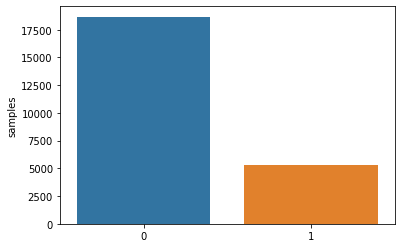

In [0]:
print("No of possitive samples : ", len(df.loc[df["NEXT_MONTH_DEFAULT"]==1]))
print("No of negative samples : ", len(df.loc[df["NEXT_MONTH_DEFAULT"]==0]))
target = df.NEXT_MONTH_DEFAULT.value_counts()
sns.barplot(target.index, target)
plt.gca().set_ylabel('samples') #gca - gets current axis of current figure

As we can see, there is a huge imbalanced between Class ditribution.

**Analysing Feature Co-relations** 

Generating the correlation matrix

In [0]:
def correlation_heatmap(data):
    correlations = data.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=False, cbar_kws={"shrink": 1.0})
    plt.show()
    return correlations


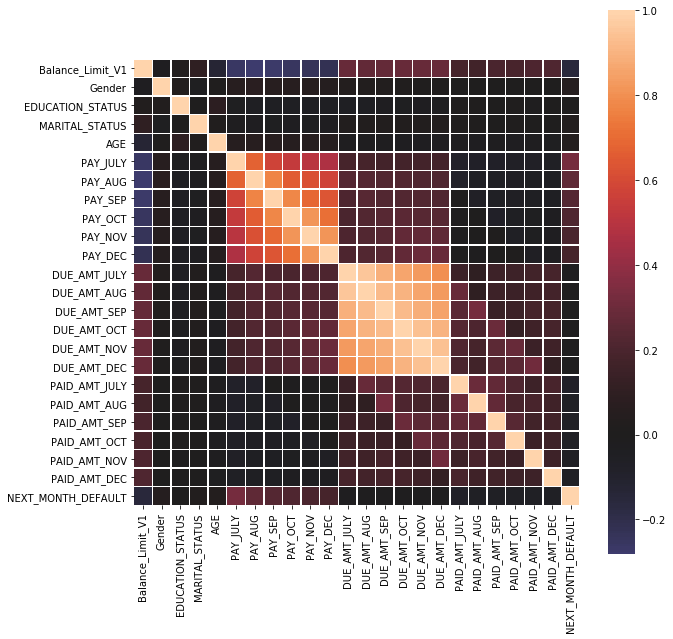

In [0]:
correlations = correlation_heatmap(df)

***From above co-relation matrix, we can observe that,***

1.   DUE_AMT_XXX columns are highly co-related with each other. 
2.   PAY_XXX columns are highly co-related with each other.
3.   PAID_AMT_XXX and Balance limit column has a  negative co-relation with          target column.
4.   PAY_XXX column has a positive co-relation with the target column.  



Selecting DUE_AMT_XX , PAID_AMT_XX columns to apply PCA

Doing PCA seperately for Categorical and Non categorical data.

In [0]:
DUE_PAID  = df[['DUE_AMT_JULY', 'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT',
       'DUE_AMT_NOV', 'DUE_AMT_DEC', 'PAID_AMT_JULY', 'PAID_AMT_AUG',
       'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC']].copy()
DUE_PAID_TEST = test_data_[['DUE_AMT_JULY', 'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT',
       'DUE_AMT_NOV', 'DUE_AMT_DEC', 'PAID_AMT_JULY', 'PAID_AMT_AUG',
       'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC']].copy()


Selecting PAY_X columns to apply PCA

In [0]:

PAY = df[['PAY_JULY', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV',
       'PAY_DEC']].copy()
PAY_TEST = test_data_[['PAY_JULY', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV',
       'PAY_DEC']].copy()


Keeping the other columns seperately

In [0]:
BEGIN_DUE_PAID = df[['Balance_Limit_V1', 'Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS',
       'AGE', 'PAY_JULY', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV',
       'PAY_DEC']].copy()

BEGIN_DUE_PAID_TEST = test_data_[['Balance_Limit_V1', 'Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS',
       'AGE', 'PAY_JULY', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV',
       'PAY_DEC']].copy()

In [0]:
BEGIN_PAY = df[['Balance_Limit_V1', 'Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS','AGE']].copy()

BEGIN_PAY_TEST = test_data_[['Balance_Limit_V1', 'Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE']].copy()

**Standardising features to have a mean = 0 and SD = 1**


Before applying PCA, features should be standardised.

In [0]:
standardScaler = preprocessing.StandardScaler()

In [0]:
for feature in DUE_PAID.columns:
  DUE_PAID[feature]= standardScaler.fit_transform(DUE_PAID[feature].values.reshape(-1,1))
  DUE_PAID_TEST[feature]= standardScaler.fit_transform(DUE_PAID_TEST[feature].values.reshape(-1,1))
for feature in PAY.columns:
  PAY[feature]= standardScaler.fit_transform(PAY[feature].values.reshape(-1,1))
  PAY_TEST[feature]= standardScaler.fit_transform(PAY_TEST[feature].values.reshape(-1,1))

Applying PCA on both training and test data set ( on selected columns )

In [0]:
pca1 = PCA(.95) #keeping 95% of variance from the original dataset
pca1.fit(DUE_PAID.copy()) #only to the train set
DUE_PAID_PCA = pca1.transform(DUE_PAID.copy())
DUE_PAID_TEST_PCA = pca1.transform(DUE_PAID_TEST.copy())

In [0]:
pca2 = PCA(.95) #keeping 95% of variance from the original dataset
pca2.fit(PAY.copy()) #only to the train set
PAY_PCA = pca2.transform(PAY.copy())
PAY_TEST_PCA = pca2.transform(PAY_TEST.copy())

In [0]:
DATA_PCA1 = pd.concat([BEGIN_DUE_PAID, pd.DataFrame( data = DUE_PAID_PCA, columns=["pca1","pca2","pca3","pca4","pca5","pca6","pca7"])], axis=1)
TEST_PCA1 = pd.concat([BEGIN_DUE_PAID_TEST, pd.DataFrame( data = DUE_PAID_TEST_PCA, columns=["pca1","pca2","pca3","pca4","pca5","pca6","pca7"])], axis=1)

In [161]:
TEST_PCA1.head(10)

,Balance_Limit_V1,Gender,EDUCATION_STATUS,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,pca1,pca2,pca3,pca4,pca5,pca6,pca7
0,500000.0,1,1,2,1,0,0,0,0,0,0,3.300430,1.839985,1.539784,-1.382432,-1.209324,3.365593,0.004730
1,200000.0,2,1,2,1,0,0,0,0,0,0,-0.257688,-0.429331,0.048548,-0.070189,-0.037592,0.037578,0.036935
2,400000.0,1,1,1,2,-1,-1,2,0,0,-1,-1.548812,0.185950,-0.431524,0.780763,-0.371296,0.122458,0.027763
3,1500000.0,1,2,2,1,1,-1,-1,-2,-2,-2,-1.751891,-0.136837,0.138061,0.037236,0.121950,-0.042778,-0.027930
4,100000.0,2,3,1,2,0,0,-2,-2,-2,-2,-1.627346,-0.363417,0.047380,-0.000381,-0.034428,0.049697,0.005039
5,100000.0,2,1,1,2,0,0,0,0,0,0,-1.284953,-0.241930,0.065205,0.002893,0.020839,0.017034,-0.035301
6,200000.0,2,3,1,2,2,2,2,2,2,2,0.176481,-0.497556,0.121053,0.101240,-0.081434,-0.097319,0.183058
7,500000.0,1,1,2,1,0,0,0,-2,-2,-2,-1.749166,-0.270952,0.084869,0.004860,0.001787,0.026112,-0.049388
8,500000.0,1,1,1,2,-1,-1,-1,-1,-1,-1,-1.737734,-0.146098,0.054702,-0.001280,0.021346,0.051784,0.086268
9,400000.0,2,1,2,3,0,0,0,0,0,0,0.645246,-0.710405,0.043975,0.007891,-0.032583,0.021387,-0.029208


Concat PCA applied features with the normal ones.

In [0]:
DATA_PCA2 = pd.concat([BEGIN_PAY, pd.DataFrame( data = PAY_PCA, columns=["pca1","pca2","pca3","pca4","pca5"]),pd.DataFrame( data = DUE_PAID_PCA, columns=["pca6","pca7","pca8","pca9","pca10","pca11","pca12"])], axis=1)
TEST_PCA2 = pd.concat([BEGIN_PAY_TEST, pd.DataFrame( data = PAY_TEST_PCA, columns=["pca1","pca2","pca3","pca4","pca5"]),pd.DataFrame( data = DUE_PAID_TEST_PCA, columns=["pca6","pca7","pca8","pca9","pca10","pca11","pca12"])], axis=1)

**Co-relation matrix after PCA1**

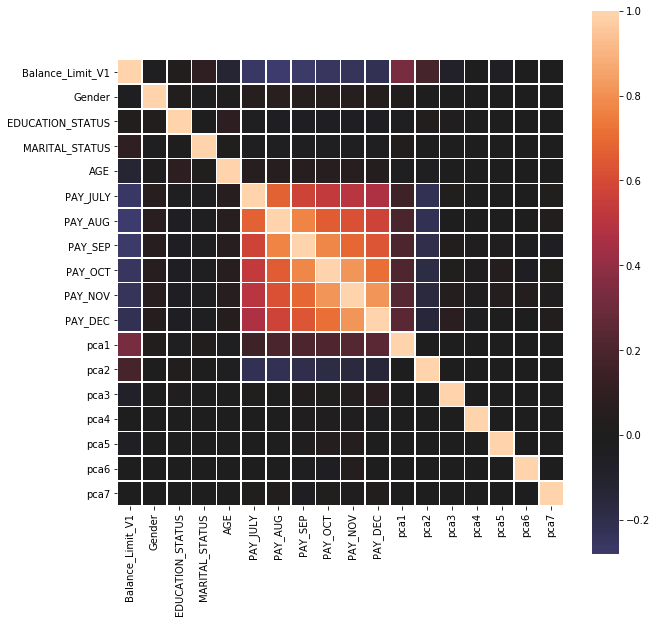

In [58]:
correlations = correlation_heatmap(DATA_PCA1)

**Co-relation matrix after PCA2**

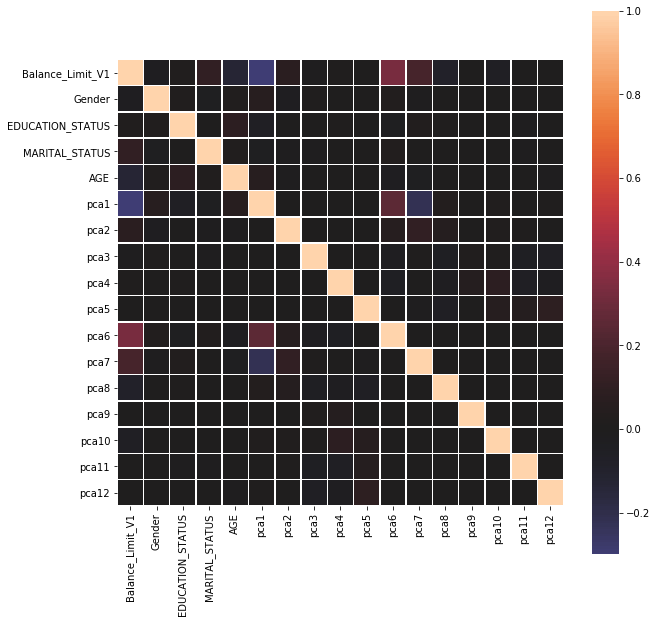

In [59]:
correlations2 = correlation_heatmap(DATA_PCA2)

As we can observe from above two matices, we can clearly see that the independency between features is preserved after appltying PCA.

In [0]:
#training data
X_TRAIN_PCA1 = DATA_PCA1.copy()
X_TRAIN_PCA2 = DATA_PCA2.copy()
X_train_ori = df.iloc[:, :-1]

#target variable
Y      = df["NEXT_MONTH_DEFAULT"]

**To overcome the issue of Imbalanced Dataset, We used SMOTE balancing algorithm. Using that we generated new synthesised minority datasets to equal with majority class.**

In [103]:
#original dataset's class distribution
counter = Counter(Y)
print(counter)

Counter({0: 18670, 1: 5330})


**Upsampling the minority class.**

In [0]:
oversample = SMOTE()
X1, Y1 = oversample.fit_resample(X_TRAIN_PCA1, Y)

In [167]:
#class distribution after applying SMOTE
counter = Counter(Y1)
print(counter)

Counter({0: 18670, 1: 18670})


In [0]:
#converting numpy array back into pandas data frame
X_df = pd.DataFrame(data = X1, columns=['Balance_Limit_V1', 'Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS',
       'AGE', 'PAY_JULY', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV',
       'PAY_DEC', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7'])

Y_df = pd.DataFrame(data = Y1, columns=['NEXT_MONTH_DEFAULT'])

**Class Distribution after SMOTE**

No of possitive samples :  18670
No of negative samples :  18670


Text(0, 0.5, 'samples')

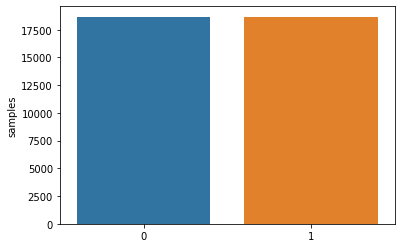

In [169]:
print("No of possitive samples : ", len(Y_df.loc[Y_df["NEXT_MONTH_DEFAULT"]==1]))
print("No of negative samples : ", len(Y_df.loc[Y_df["NEXT_MONTH_DEFAULT"]==0]))
target = Y_df.NEXT_MONTH_DEFAULT.value_counts()
sns.barplot(target.index, target)
plt.gca().set_ylabel('samples') #gca - gets current axis of current figure

As we can see, now the dataset is completely balanced with new synthesised minority classes.

**Dividing the dataset into train and test sets.**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
...     X_TRAIN_PCA1, Y, test_size=0.2, random_state=42) #without SMOTE

In [0]:
X3_train, X3_test, y3_train, y3_test = train_test_split(
...     X_df, Y_df, test_size=0.2, random_state=42) #with SMOTE

**Testing Out Balanced Bagging Classifier with Random forest and PCA**

**Utils**

In [0]:
def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist()
    feat = ftrs
    result = pd.DataFrame({'feature':feat,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

In [0]:
def classification( classifier , X_train, X_test, Y_train, Y_test):
    classifier.fit(X_train, Y_train)
    y_pred = classifier.predict(X_test)
    score  = classifier.score(X_test,Y_test)
    report = classification_report(Y_test, y_pred)
    cm     = confusion_matrix(Y_test, y_pred)
    return score, report, cm

In [0]:
def Submission( classifier , X_train, X_test, Y_train):
    classifier.fit(X_train, Y_train)
    y_pred = classifier.predict(X_test)
    output = pd.DataFrame( data = {'Client_ID': test_data['Client_ID'], 'NEXT_MONTH_DEFAULT': y_pred})
    return output

**RandomizedSearchCV for optimal Parameters**

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 30, num = 15)]
max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(2, 50, num = 25)]
# Minimum number of samples to split an internal node
min_samples_split = [int(x) for x in np.linspace(2, 100, num = 50)]
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=268)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split' : min_samples_split,
               'n_jobs' : [-1],
               'random_state' : [42]}

In [0]:
grid_forest = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, 
                               n_iter = 50, cv = skf, random_state=42, n_jobs = -1,
                                scoring = 'accuracy')

In [0]:
grid_forest.fit(X_train, y_train)

#let's see the best estimator
best_forest = grid_forest.best_estimator_
print(best_forest)
print("_"*40)
#with its score
print("Cross-validated best score {}%".format(round(grid_forest.best_score_ * 100,3)))
#score on test
predictions = best_forest.predict(X_test)

Different Classifiers

In [0]:
RF = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=14, min_samples_split=72,
                       min_weight_fraction_leaf=0.0, n_estimators=115,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False) #from RandomizedSearch

In [0]:
RF2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=46, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=178,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
RF3 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=88,
                       min_weight_fraction_leaf=0.0, n_estimators=52, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
XGB  = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=401,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


In [0]:
BBC = BalancedBaggingClassifier( base_estimator = RF2 , random_state=0 )

**Algorithm selected :  XGBoost**

In [0]:
score , report, cm = classification( XGB , X3_train, X3_test, y3_train, y3_test)

In [159]:
print(report)  # XGB with SMOTE

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      3734
           1       0.85      0.62      0.72      2241

    accuracy                           0.82      5975
   macro avg       0.83      0.78      0.79      5975
weighted avg       0.82      0.82      0.81      5975



In [143]:
cm # XGB with SMOTE

array([[3001,  733],
       [ 728, 1513]])

In [0]:
output = Submission( XGB, X_df,  TEST_PCA1, Y_df )

In [0]:
output.to_csv("/content/Submission4.csv", index = False, quoting=3)